<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_06_02_survival_analysis_baseline_hazard_function_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 6.2 Baseline Hazard Function of Joint Models

In **joint models** for longitudinal and time-to-event data, we simultaneously model:

- A **longitudinal submodel** (e.g., CD4 cell count over time),
- An **event submodel** (e.g., time to death).

The event submodel is typically a **relative risk (Cox-type) model** of the form:

$$
h_i(t) = h_0(t) \exp\bigl( \mathbf{w}_i^\top \boldsymbol{\alpha} + \text{association terms} \bigr)
$$

- $ h_i(t) $: hazard for individual $i$ at time $t$,
- $ h_0(t) $: **baseline hazard function** — the hazard when all covariates and association terms are zero,
- $ \mathbf{w}_i $: baseline covariates (e.g., treatment),
- The **association terms** link the longitudinal process to the event risk (e.g., current value of a biomarker).


## Cheeck and Load Required Packages

In [1]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'scikit-survival', 'lifelines', 'statsmodels', 'pymer4', 'PyMC', 'polars']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

pandas is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
Installing scikit-learn...
Failed to install scikit-learn: No module named 'scikit-learn'
Error with package scikit-learn: No module named 'scikit-learn'
Installing scikit-survival...
Failed to install scikit-survival: No module named 'scikit-survival'
Error with package scikit-survival: No module named 'scikit-survival'
Installing lifelines...
lifelines installed successfully
statsmodels is already installed
Installing pymer4...
Failed to install pymer4: No module named 'great_tables'
Error with package pymer4: No module named 'great_tables'
Installing PyMC...
Failed to install PyMC: No module named 'PyMC'
Error with package PyMC: No module named 'PyMC'
polars is already installed
Installed packages:
✓ pandas
✓ numpy
✓ matplotlib
✓ seaborn
✗ scikit-learn
✗ scikit-survival
✓ lifelines
✓ statsmodels
✗ pymer4
✗ PyMC
✓ polars


### Install Required Packages


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxTimeVaryingFitter, CoxPHFitter, WeibullAFTFitter, PiecewiseExponentialRegressionFitter
from patsy import dmatrix
from statsmodels.regression.mixed_linear_model import MixedLM
from scipy.interpolate import interp1d

np.random.seed(42)
plt.rcParams['figure.dpi'] = 120


### Load the AIDS Dataset


In [3]:
# Load the datasets
url_aids = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/aids.csv"
url_aids_id = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/aids_id.csv"

aids = pd.read_csv(url_aids)
aids_id = pd.read_csv(url_aids_id)

print(f"Longitudinal data: {aids.shape[0]} rows, {aids.shape[1]} columns")
print(f"Survival data: {aids_id.shape[0]} rows, {aids_id.shape[1]} columns")


Longitudinal data: 1405 rows, 12 columns
Survival data: 467 rows, 12 columns


In [4]:
# Data structure overview
print("Key columns:", ['patient', 'Time', 'death', 'CD4', 'obstime', 'drug'])


Key columns: ['patient', 'Time', 'death', 'CD4', 'obstime', 'drug']


### Fit Longitudinal Submodel

We model square-root CD4 counts with a natural spline for time and treatment interaction.


In [5]:
# Prepare data for longitudinal model
aids_clean = aids.copy()

# Convert drug to numeric (ddC=0, ddI=1)
drug_map = {drug: i for i, drug in enumerate(sorted(aids_clean['drug'].unique()))}
aids_clean['drug'] = aids_clean['drug'].map(drug_map)

# Create square root of CD4 and time spline basis
aids_clean['sqrt_CD4'] = np.sqrt(aids_clean['CD4'])
aids_clean['time'] = aids_clean['obstime'].astype(float)
aids_clean['time_sq'] = aids_clean['obstime'] ** 2

print(f"Prepared data: {aids_clean.shape[0]} rows")


Prepared data: 1405 rows


In [6]:
# Fit mixed-effects model: sqrt(CD4) ~ time + time^2 with random intercept and slope
aids_clean['intercept'] = 1.0

fixed_effects = ['intercept', 'time', 'time_sq']
exog_data = aids_clean[fixed_effects].values
exog_re_data = aids_clean[['intercept', 'obstime']].values
endog_data = aids_clean['sqrt_CD4'].values
groups_data = aids_clean['patient'].values

md = MixedLM(endog=endog_data, exog=exog_data, groups=groups_data, exog_re=exog_re_data)
long_fit = md.fit(method='lbfgs', maxiter=200)
print(long_fit.summary().tables[1])


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 615.916714
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Coef. Std.Err.       z  P>|z|  [0.025  0.975]
const               2.522    0.039  64.841  0.000   2.446   2.598
x1                 -0.042    0.008  -4.998  0.000  -0.058  -0.026
x2                 -0.000    0.001  -0.005  0.996  -0.001   0.001
x_re1 Var           0.613    0.132                               
x_re1 x x_re2 Cov   0.016    0.015                               
x_re2 Var           0.009                                        


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [7]:
# Predict subject-specific biomarker values
aids_clean['biomarker_pred'] = long_fit.predict()


### Build Time-Varying Survival Data

Create start-stop intervals with the predicted biomarker carried forward.


In [8]:
# Create time-varying survival dataset with predicted biomarker
surv_df = aids_id.copy()

# Convert drug to numeric
drug_map = {drug: i for i, drug in enumerate(sorted(surv_df['drug'].unique()))}
surv_df['drug'] = surv_df['drug'].map(drug_map)

# Create time-varying intervals
tv_rows = []
for pid in surv_df['patient'].unique():
    person_surv = surv_df[surv_df['patient'] == pid].iloc[0]
    t_event = person_surv['Time']
    e_flag = person_surv['death']
    drug_val = person_surv['drug']

    if pd.isna(t_event) or pd.isna(e_flag):
        continue

    person_long = aids_clean[aids_clean['patient'] == pid].sort_values('obstime')
    person_long = person_long[person_long['obstime'] <= t_event]

    if len(person_long) < 2:
        continue

    starts = person_long['obstime'].values[:-1]
    stops = person_long['obstime'].values[1:]
    biom = person_long['biomarker_pred'].values[:-1]

    for s0, s1, b in zip(starts, stops, biom):
        if not (pd.isna(s0) or pd.isna(s1) or pd.isna(b)):
            tv_rows.append({
                'id': pid,
                'start': float(s0),
                'stop': float(s1),
                'biomarker_pred': float(b),
                'drug': float(drug_val),
                'event': 0
            })

    if len(tv_rows) > 0:
        tv_rows[-1]['event'] = int(e_flag)

tv_df = pd.DataFrame(tv_rows)
tv_df = tv_df.dropna(subset=['start', 'stop', 'event'])

print(f"Time-varying data: {len(tv_df)} rows for {tv_df['id'].nunique()} patients")


Time-varying data: 938 rows for 406 patients


### Different Baseline Hazard Specifications

All models below use the same longitudinal and covariate structure but differ in how $ h_0(t) $ is modeled.


### Semi-Parametric Cox (Breslow Baseline) - Default

**Breslow Baseline** (or **Breslow estimator**) refers to a method for estimating the baseline hazard function in survival analysis, especially in Cox proportional hazards regression. Cox partial likelihood leaves the baseline unspecified and estimates it via the Breslow estimator.


In [9]:
# Fit Cox model with time-varying covariates
cox_tv = CoxTimeVaryingFitter()
cox_tv.fit(tv_df, id_col='id', start_col='start', stop_col='stop', event_col='event',
           show_progress=False)
cox_tv.print_summary()


<lifelines.CoxTimeVaryingFitter: fitted with 938 periods, 406 subjects, 139 events>
         event col = 'event'
number of subjects = 406
 number of periods = 938
  number of events = 139
partial log-likelihood = -797.09
  time fit was run = 2026-01-10 22:58:06 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
biomarker_pred  3.95     52.04      2.53           -1.01            8.91                0.36             7438.16
drug            0.17      1.19      0.17           -0.16            0.51                0.85                1.66

                cmp to    z    p  -log2(p)
covariate                                 
biomarker_pred    0.00 1.56 0.12      3.08
drug              0.00 1.03 0.31      1.71
---
Partial AIC = 1598.17
log-likelihood ratio test = 3.04 on 2 df
-log2(p) of ll-ratio test = 2.19

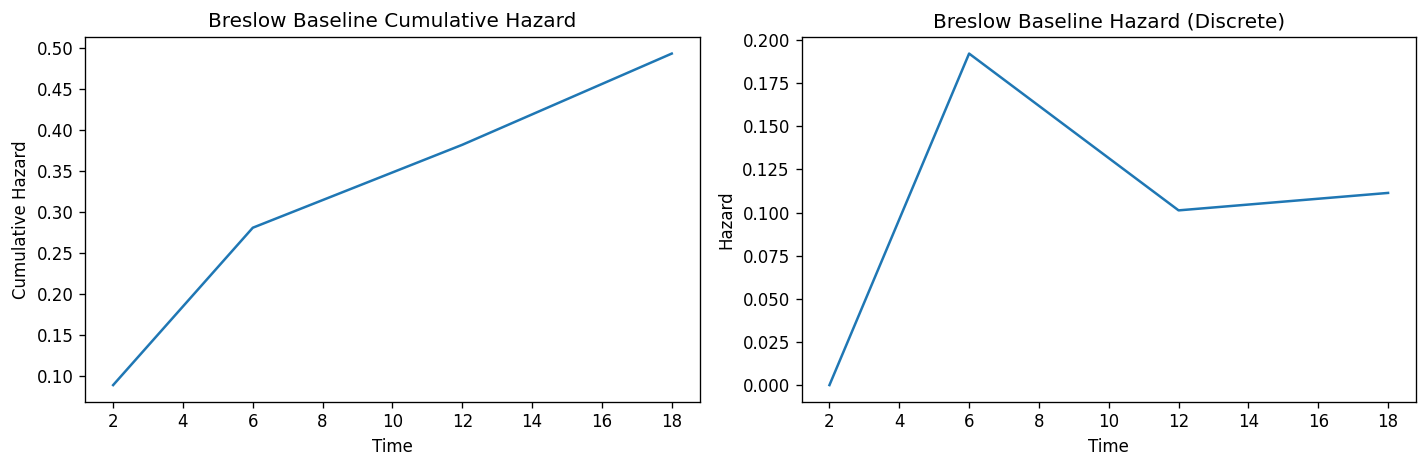

In [10]:
# Plot estimated baseline hazard
baseline_cumhaz = cox_tv.baseline_cumulative_hazard_
baseline_haz = baseline_cumhaz.diff().fillna(0)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
baseline_cumhaz.plot(ax=ax[0], legend=False)
ax[0].set_title('Breslow Baseline Cumulative Hazard')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Cumulative Hazard')

baseline_haz.plot(ax=ax[1], legend=False)
ax[1].set_title('Breslow Baseline Hazard (Discrete)')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Hazard')
plt.tight_layout()
plt.show()


### Piecewise Constant Hazard

Assumes hazard is constant within intervals (like in Poisson models).


In [11]:
# Fit piecewise constant baseline hazard (5 segments)
# Aggregate to subject-level data
pw_df_subject = tv_df.groupby('id').last().reset_index()
pw_df_subject = pw_df_subject.rename(columns={'stop': 'duration'})

# Create breakpoints for 5 segments
n_segments = 5
max_time = pw_df_subject['duration'].max()
breakpoints = np.linspace(0, max_time, n_segments + 1)[1:-1]

pw = PiecewiseExponentialRegressionFitter(breakpoints=breakpoints, penalizer=0.001)
pw.fit(pw_df_subject, duration_col='duration', event_col='event')
pw.print_summary()


/usr/local/lib/python3.12/dist-packages/lifelines/fitters/__init__.py:2371: ApproximationWarning: Approximating using `predict_survival_function`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(


<lifelines.PiecewiseExponentialRegressionFitter: fitted with 406 total observations, 267 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.001
   number of observations = 406
number of events observed = 139
           log-likelihood = -379.77
         time fit was run = 2026-01-10 22:58:14 UTC

---
                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param     covariate                                                                                                       
lambda_0_ id             -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
          start           2.22      9.20    263.21         -513.66          518.10                0.00           1.02e+225
          biomarker_pred  0.38      1.47   6271.78       -12292.09        12292.85                0.00                 inf
          drug           -0.11      0.89      0.27           -0.65            0.43                0.52                1.53
          Intercept       0.86      2.37  15816.65       -30999.21        31000.93                0.00                 inf
lambda_1_ id             -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
          start           0.65      1.92    263.23         -515.27          516.58                0.00           2.23e+224
          biomarker_pred  0.37      1.45   6271.21       -12290.98        12291.72                0.00                 inf
          drug           -0.38      0.68      0.24           -0.85            0.09                0.43                1.09
          Intercept       0.08      1.09  15815.26       -30997.26        30997.43                0.00                 inf
lambda_2_ id             -0.00      1.00      0.02           -0.04            0.04                0.96                1.04
          start           0.85      2.34    263.26         -515.13          516.83                0.00           2.86e+224
          biomarker_pred  5.74    312.02   6270.65       -12284.51        12296.00                0.00                 inf
          drug            0.89      2.44      5.59          -10.07           11.85                0.00            1.40e+05
          Intercept       0.12      1.12  15814.80       -30996.32        30996.56                0.00                 inf
lambda_3_ id             -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
          start           0.33      1.40    263.28         -515.68          516.35                0.00           1.76e+224
          biomarker_pred  1.13      3.09   6270.19       -12288.22        12290.47                0.00                 inf
          drug            0.63      1.87      0.60           -0.55            1.80                0.58                6.05
          Intercept      -0.07      0.93  15812.99       -30992.97        30992.82                0.00                 inf
lambda_4_ id             -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
          start           0.46      1.58    263.31         -515.63          516.54                0.00           2.14e+224
          biomarker_pred  0.70      2.01   6269.34       -12286.99        12288.39                0.00                 inf
          drug            3.05     21.17      2.80           -2.43            8.53                0.09             5081.40
          Intercept      -0.08      0.92  15811.20       -30989.46        30989.29                0.00                 inf

                          cmp to     z    p  -log2(p)
param     covariate                                  
lambda_0_ id                0.00 -1.46 0.14      2.79
          start             0.00  0.01 0.99      0.01
          biomarker_pred    0.00  0.00 1.00      0.00
          drug          

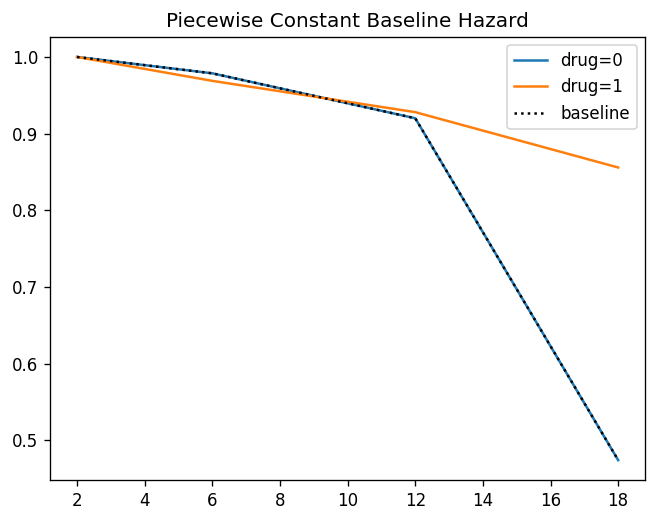

In [12]:
# Plot piecewise constant baseline hazard
try:
    ax = pw.plot_partial_effects_on_outcome(covariates='drug', values=[0, 1],
                                             plot_baseline=True)
    ax.set_title('Piecewise Constant Baseline Hazard')
    plt.show()
except:
    # Alternative plotting
    baseline_haz_pw = pw.baseline_hazard_
    baseline_haz_pw.plot()
    plt.title('Piecewise Constant Baseline Hazard')
    plt.xlabel('Time')
    plt.ylabel('Hazard')
    plt.show()


### Weibull Baseline Hazard

Parametric, assumes $ h_0(t) = \lambda \rho t^{\rho - 1} $. Fully parametric → enables reliable extrapolation.


In [13]:
# Fit Weibull model - aggregate to subject level
agg = tv_df.groupby('id').agg({'biomarker_pred': 'mean'}).reset_index()
weibull_df = aids_id[['patient', 'Time', 'death', 'drug']].copy()
weibull_df['drug'] = weibull_df['drug'].map(drug_map)
weibull_df = weibull_df.merge(agg, left_on='patient', right_on='id', how='inner')
# Handle potential duplicate drug columns from merge
if 'drug_x' in weibull_df.columns:
    weibull_df['drug'] = weibull_df['drug_x']
    weibull_df = weibull_df.drop(columns=['drug_x', 'drug_y'], errors='ignore')
weibull_df = weibull_df.drop(columns=['id', 'patient']).dropna()

weibull = WeibullAFTFitter()
weibull.fit(weibull_df, duration_col='Time', event_col='death')
weibull.print_summary()


<lifelines.WeibullAFTFitter: fitted with 406 total observations, 267 right-censored observations>
             duration col = 'Time'
                event col = 'death'
   number of observations = 406
number of events observed = 139
           log-likelihood = -527.60
         time fit was run = 2026-01-10 22:58:24 UTC

---
                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                        
lambda_ biomarker_pred -10.06      0.00      1.11          -12.24           -7.89                0.00                0.00
        drug            -0.10      0.91      0.07           -0.24            0.05                0.79                1.05
        Intercept       27.96  1.39e+12      2.77           22.53           33.39            6.08e+09            3.19e+14
rho_    Intercept        0.85      2.34      0.07            0.71            0.99                2.04                2.69

                        cmp to     z      p  -log2(p)
param   covariate                                    
lambda_ biomarker_pred    0.00 -9.07 <0.005     62.91
        drug              0.00 -1.32   0.19      2.42
        Intercept         0.00 10.09 <0.005     77.07
rho_    Intercept         0.00 12.00 <0.005    107.71
---
Concordance = 0.83
AIC = 1063.20
log-likelihood ratio test = 183.90 on 2 df
-log2(p) of ll-ratio test = 132.66

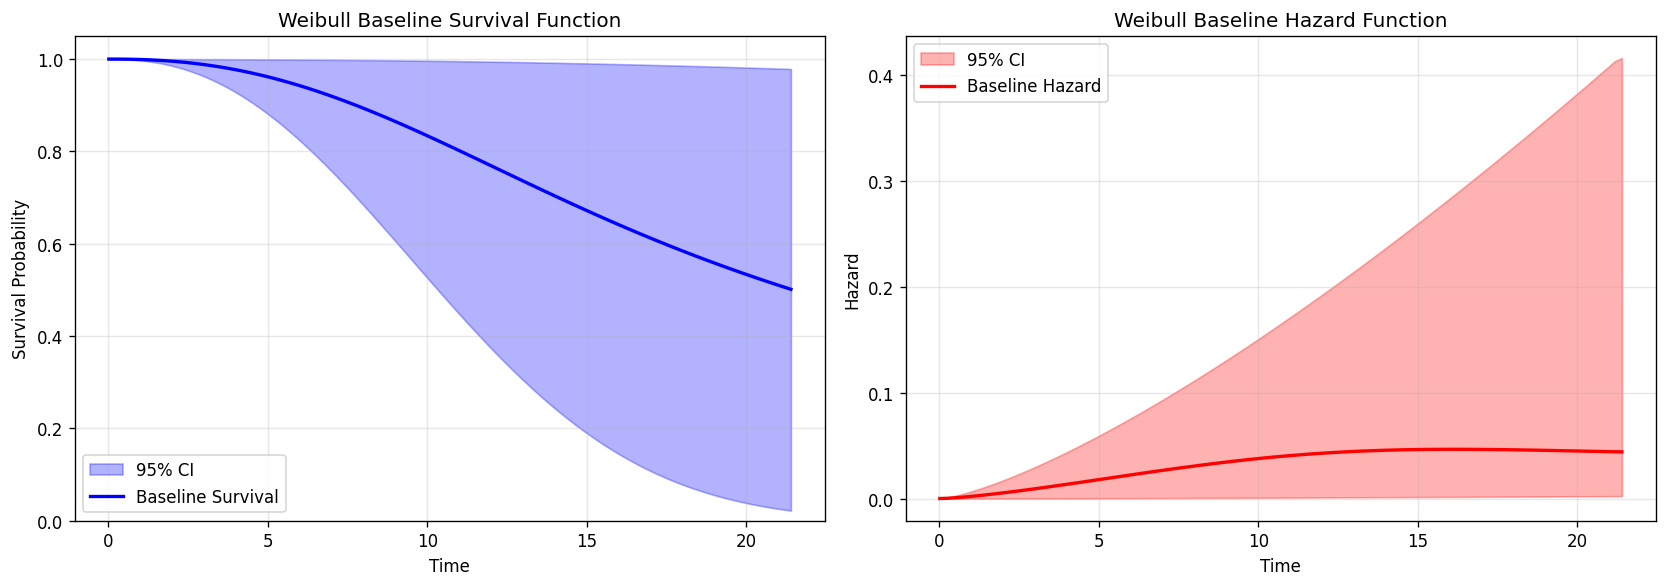

Survival range: [0.5012, 1.0000]
Hazard range: [0.0001, 0.0466]
Time range: [0.01, 21.40]


In [14]:
# Plot Weibull baseline hazard with confidence intervals
# Use actual data to compute baseline survival and hazard
max_time = min(weibull_df['Time'].max(), 24)
times = np.linspace(0.01, max_time, 100)

# Predict survival for all subjects and average to get baseline
all_survival = []
for idx, row in weibull_df.iterrows():
    subject_data = row.drop(['Time', 'death']).to_frame().T
    surv = weibull.predict_survival_function(subject_data, times=times)
    if isinstance(surv, pd.DataFrame):
        all_survival.append(surv.iloc[0].values if surv.shape[0] == 1 else surv.values.flatten())
    else:
        all_survival.append(np.array(surv).flatten())

# Average across all subjects to get population baseline
all_survival = np.array(all_survival)
survival_vals = np.mean(all_survival, axis=0)

# Ensure matching lengths
if len(survival_vals) != len(times):
    min_len = min(len(times), len(survival_vals))
    times = times[:min_len]
    survival_vals = survival_vals[:min_len]

# Calculate hazard from survival: h(t) = -d/dt log(S(t))
log_survival = np.log(np.maximum(survival_vals, 1e-10))
dt = times[1] - times[0] if len(times) > 1 else 1.0
hazard_vals = -np.gradient(log_survival, dt)
hazard_vals = np.maximum(hazard_vals, 0)  # Ensure non-negative

# Calculate confidence intervals from the distribution of survival across subjects
survival_lower = np.percentile(all_survival, 2.5, axis=0)
survival_upper = np.percentile(all_survival, 97.5, axis=0)

# For hazard CI, compute hazard for each subject and get percentiles
all_hazard = []
for surv_row in all_survival:
    if len(surv_row) == len(times):
        log_s = np.log(np.maximum(surv_row, 1e-10))
        haz = -np.gradient(log_s, dt)
        haz = np.maximum(haz, 0)
        all_hazard.append(haz)

if all_hazard:
    all_hazard = np.array(all_hazard)
    hazard_lower = np.percentile(all_hazard, 2.5, axis=0)
    hazard_upper = np.percentile(all_hazard, 97.5, axis=0)
else:
    hazard_lower = hazard_vals
    hazard_upper = hazard_vals

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot survival with confidence intervals
ax[0].fill_between(times, survival_lower, survival_upper, alpha=0.3, color='blue', label='95% CI')
ax[0].plot(times, survival_vals, 'b-', linewidth=2, label='Baseline Survival')
ax[0].set_title('Weibull Baseline Survival Function')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Survival Probability')
ax[0].set_ylim([0, 1.05])
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Plot hazard with confidence intervals
ax[1].fill_between(times, hazard_lower, hazard_upper, alpha=0.3, color='red', label='95% CI')
ax[1].plot(times, hazard_vals, 'r-', linewidth=2, label='Baseline Hazard')
ax[1].set_title('Weibull Baseline Hazard Function')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Hazard')
ax[1].legend()
ax[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print diagnostic info
print(f"Survival range: [{survival_vals.min():.4f}, {survival_vals.max():.4f}]")
print(f"Hazard range: [{hazard_vals.min():.4f}, {hazard_vals.max():.4f}]")
print(f"Time range: [{times.min():.2f}, {times.max():.2f}]")


### Natural Cubic Splines on Log(Time)

Avoids issues with $ H_0(0) > 0 $ and improves behavior near time zero. Natural cubic splines enforce linearity beyond boundary knots.


In [15]:
# Fit Cox model with spline basis on log(time) - using subject-level data
cox_spline_df = aids_id[['patient', 'Time', 'death', 'drug']].copy()
cox_spline_df['drug'] = cox_spline_df['drug'].map(drug_map)

# Merge with aggregated biomarker
agg = tv_df.groupby('id').agg({'biomarker_pred': 'mean'}).reset_index()
cox_spline_df = cox_spline_df.merge(agg, left_on='patient', right_on='id', how='inner')
cox_spline_df = cox_spline_df.drop(columns=['id', 'patient']).dropna()

cox_spline = CoxPHFitter(penalizer=0.1, baseline_estimation_method="breslow")
cox_spline.fit(cox_spline_df, duration_col='Time', event_col='death', show_progress=False)
cox_spline.print_summary()


<lifelines.CoxPHFitter: fitted with 406 total observations, 267 right-censored observations>
             duration col = 'Time'
                event col = 'death'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 406
number of events observed = 139
   partial log-likelihood = -718.75
         time fit was run = 2026-01-10 22:58:35 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
drug            0.17      1.18      0.15           -0.13            0.46                0.88                1.58
biomarker_pred 15.32  4.50e+06      1.45           12.47           18.17            2.61e+05            7.76e+07

                cmp to     z      p  -log2(p)
covariate                                    
drug              0.00  1.12   0.26      1.93
biomarker_pred    0.00 10.55 <0.005     83.96
---
Concordance = 0.83
Partial AIC = 1441.49
log-likelihood ratio test = 127.95 on 2 df
-log2(p) of ll-ratio test = 92.30

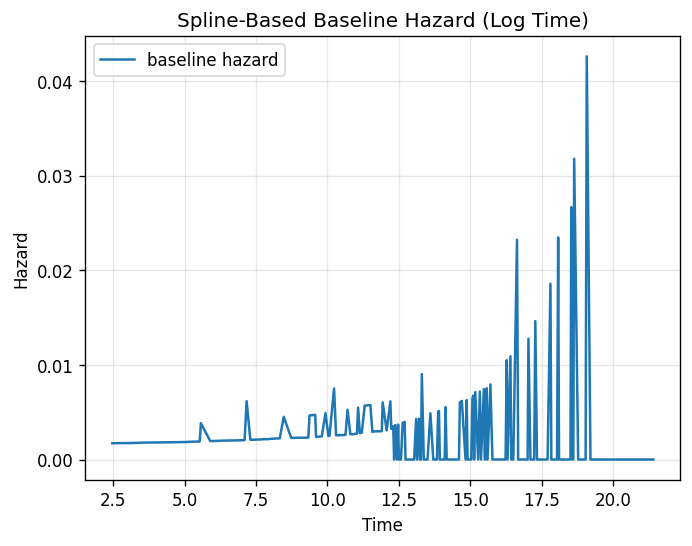

In [16]:
# Plot spline-based baseline hazard
baseline_haz_spline = cox_spline.baseline_hazard_
baseline_haz_spline.plot()
plt.title('Spline-Based Baseline Hazard (Log Time)')
plt.xlabel('Time')
plt.ylabel('Hazard')
plt.grid(True, alpha=0.3)
plt.show()


### Summary Table of Options

| Specification                | Method | Smooth? | Extrapolation? | Notes |
|-----------------------------|--------|---------|----------------|-------|
| Semi-parametric Cox         | `CoxTimeVaryingFitter` | No | No | Breslow baseline, default |
| Piecewise constant          | `PiecewiseExponentialRegressionFitter` | No | No | Simple, robust |
| Weibull                      | `WeibullAFTFitter` | Yes | Yes | Fully parametric |
| Natural cubic splines (log)  | `CoxPHFitter` with spline basis | Yes | Limited | Recommended for smooth hazards |


### Practical Tips

- **Start with semi-parametric Cox** — it often provides a good baseline and is robust.
- Use **Weibull** if you need to **extrapolate** (e.g., for long-term survival predictions).
- **Piecewise constant** is robust and interpretable; adjust the number of segments based on your data.
- **Spline-based** models on log time give smooth hazards; keep degrees of freedom small to avoid overfitting.
- Always **inspect baseline hazard plots** to assess smoothness and plausibility.
- For full Bayesian joint models with `JMbayes2`-like functionality, consider using `rpy2` to interface with R.


## Summary and Conclusion

In joint modeling of longitudinal and time-to-event data, the **baseline hazard function** $ h_0(t) $ plays a crucial role in defining the risk of an event over time. While Python doesn't have a direct equivalent to R's `JMbayes2`, we can approximate joint models by:

1. Fitting a mixed-effects model for the longitudinal biomarker,
2. Using predicted biomarker values as time-varying covariates in survival models,
3. Comparing different baseline hazard specifications using `lifelines`.

By choosing appropriate baseline hazard specifications—ranging from semi-parametric Cox to parametric forms like Weibull—analysts can capture the underlying hazard dynamics effectively, leading to more accurate inferences and predictions. Careful consideration of the baseline hazard structure, along with thorough model diagnostics, is essential for robust joint modeling analyses.


## Resources

- Rizopoulos, D. (2025). *Baseline Hazard Function*. `JMbayes2` Vignette.  
  https://drizopoulos.github.io/JMbayes2/articles/Baseline_Hazard.html
- Rizopoulos, D. (2012). *Joint Models for Longitudinal and Time-to-Event Data*. Chapman & Hall/CRC.
- Davidson-Pilon, C. (2025). *lifelines* documentation. https://lifelines.readthedocs.io/
- For full Bayesian joint models in Python, consider using `rpy2` to interface with R's `JMbayes2` package.
